In [2]:
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.sparse as sp
import pandas as pd
import spacy
import os

from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from os import listdir
from os.path import isfile, join
from rouge_score import rouge_scorer
from rouge import Rouge 

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge = Rouge()
nlp = spacy.load("en_core_web_sm")

Import files

In [3]:
val_preproc_dir = r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\2021val_annual_reports_prepr-20220901T133401Z-001\2021val_annual_reports_prepr"
name_of_files = [f for f in listdir(val_preproc_dir) 
             if isfile(join(val_preproc_dir, f))]
list_of_files = []
for file_name in name_of_files:
    list_of_files.append(open(val_preproc_dir + "\\" + file_name, "r").read())

Preprocess data

In [4]:
def delete_nums(txt_splited):
    res_finish = []
    for text in tqdm(txt_splited):
        res_txt = []
        for paragraph in text:
            res_par = ''
            for i in re.split('\.| ',paragraph):
                if i.isalpha():
                    res_par += i.lower().strip(",.\"'!?;:") + ' '
            res_txt.append(res_par)
        res_finish.append(res_txt)
    return res_finish

In [5]:
txt_splited = [file_txt.split('\n') for file_txt in list_of_files]
txt_str_div_par = delete_nums(txt_splited)

  0%|          | 0/363 [00:00<?, ?it/s]

In [6]:
def make_vocab(txt_str_div_par):
    txt_str = txt_str_div_par.copy()
    for i, txt in enumerate(txt_str_div_par):
        txt_str[i] = ''.join(txt)

    vocab_list = []
    for i, txt in enumerate(txt_str):
        vocab = list(re.split(' \n| ', txt))

        if '' in set(vocab):
            vocab.remove("")
        vocab_list.append(list(set(vocab)))
    return vocab_list, txt_str

In [7]:
def list_of_words_max_len(txt_str):
    list_of_words = [txt.split(' ') for txt in txt_str]
    for i in range(len(list_of_words)):
        list_of_words[i] = [w for w in list_of_words[i] if w]

    len_words = [len(v) for v in list_of_words]
    max_len_words = max(len_words)
    return list_of_words, len_words, max_len_words

make functions for calculating results in sparse matrix for time and memory optimization

download calculated matix and sum scores of the words per paragraph

In [13]:
def calculate_sum_of_art(txt_str_div_art, sum_arr_word, v_to_i, dict_weight, weights=[1, 2]):
    article_weight, len_per_art = [], []
    heavy_words = []
    for article in txt_str_div_art:
        split = [j for j in article.split(' ') if j]
        len_art = len(split)
        if len_art != 0:
            par_split = 0
            word_heavy = 0
            for word in split:
                w = weights[1] if word in dict_weight else weights[0]
                word_heavy += w // max(weights)
                par_split += sum_arr_word[v_to_i[word]] * w
            heavy_words.append(word_heavy / len_art)
            article_weight.append(float(par_split) / len_art)
            len_per_art.append(len_art)
        else:
            article_weight.append(0)
            len_per_art.append(0)
            heavy_words.append(0)
            
    return pd.DataFrame(list(zip(article_weight, len_per_art, heavy_words)), columns=['sum', 'len', 'wght'])

In [ ]:
calculate_sum_of_art(txt_str_div_art, sum_arr_word, v_to_i, [], weights=[1, 1])

In [9]:
def top_art(res):
    sorted_res = res.sort_values(by=['sum'], ascending=False)
    sorted_res['index'] = sorted_res.index

    i, len_txt = 0, 0
    num_art = []
    while i < len(sorted_res) and len_txt < 1000:
        len_txt += sorted_res.iloc(0)[i]['len']
        num_art.append(int(sorted_res.iloc(0)[i]['index'])) 
        i += 1
    num_art.sort()
    return num_art, int(len_txt)

In [8]:
def download_npz(name_of_files, vocab_list, txt_str_div_par, dir_to_upload, dict_weight, weight):
    art_sum = []
    for i_t, text_name in tqdm(enumerate(name_of_files), total=len(name_of_files)):

        #calculate best articles in txt based on matrix
        sum_arr_word = sp.load_npz(dir_to_upload + text_name[:-4] + ".npz").sum(axis=1)
        v_to_i = {v:i for i, v in enumerate(vocab_list[i_t])}
        art_sum.append(calculate_sum_of_art(txt_str_div_par[i_t], sum_arr_word, v_to_i, dict_weight, weight))
    return art_sum

In [145]:
def read_files(val_dir):
    name_of_files = [f for f in listdir(val_dir) 
                 if isfile(join(val_dir, f))]
    list_of_files = []
    for file_name in name_of_files:        
        list_of_files.append(open(val_dir + "\\" + file_name, "r", encoding='utf-8').read())
    return name_of_files, list_of_files

In [10]:
vocab_list, txt_str = make_vocab(txt_str_div_par)

In [11]:
list_of_words, len_words, max_len_words = list_of_words_max_len(txt_str)

In [15]:
dict_weight = []
for line in open(r'C:\Users\RedmiBook\Documents\SCE\proj\dict_ent.txt', 'r'):
    dict_weight.append(line)
dict_weight = [s[:-1].lower() for s in dict_weight if s[:-1].isalpha()]
dict_weight = [w for w in dict_weight if len(w) > 2]
dict_weight = set(dict_weight)

In [16]:
art_sum = download_npz(name_of_files, vocab_list, txt_str_div_par, dir_to_upload=r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\full PLM windows\PLM matrix\\", dict_weight=dict_weight, weight=[1, 2])

  0%|          | 0/363 [00:00<?, ?it/s]

In [18]:
def download_npz_word(name_of_files, dir_to_upload):
    sum_arr_word, v_to_i = [], []
    for i_t, text_name in tqdm(enumerate(name_of_files), total=len(name_of_files)):
        sum_arr_word.append(sp.load_npz(dir_to_upload + text_name[:-4] + ".npz").sum(axis=1))
        v_to_i.append({v:i for i, v in enumerate(vocab_list[i_t])})
#         art_sum.append(calculate_sum_of_art(txt_str_div_par[i_t], sum_arr_word, v_to_i, [], weight))
    return sum_arr_word, v_to_i

In [19]:
word_plm, v_to_i = download_npz_word(name_of_files, dir_to_upload=r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\full PLM windows\PLM matrix\\")

  0%|          | 0/363 [00:00<?, ?it/s]

In [20]:
def plm_list_by_words(txt_str, v_to_i, word_plm):
    plm_list = []
    for i_t, text in tqdm(enumerate(txt_str), total=len(txt_str)):
        new_m = []
        for word in text.split():
            new_m.append(word_plm[i_t][v_to_i[i_t][word]][0, 0])
        plm_list.append(new_m)
    return plm_list

In [21]:
plm_list = plm_list_by_words(txt_str, v_to_i, word_plm)

  0%|          | 0/363 [00:00<?, ?it/s]

In [22]:
gold_dir = r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\fns2020_dataset_clean\validation\gold_summaries"
name_of_files_gold = [f for f in listdir(gold_dir) 
             if isfile(join(gold_dir, f))]
list_of_files_gold = []
for file_name in name_of_files_gold:
    list_of_files_gold.append(open(gold_dir + "\\" + file_name, "r", encoding='utf-8').read())

In [15]:
def preproc(txt_splited):
    res_finish, res_glue = [], []
    for text in tqdm(txt_splited):
        res_txt = []
        for paragraph in text:
            res_par = ''
            for i in re.split('\.| ',paragraph):
                if i.isalpha():
                    res_par += i.lower() + ' '
            res_txt.append(res_par)
        res_glue.append(''.join(res_txt))
        res_finish.append(res_txt)
    return res_finish, res_glue

In [16]:
txt_splited_gold = [file_txt.split('\n') for file_txt in list_of_files_gold]
txt_str_div_par_gold, txt_str_gold = preproc(txt_splited_gold)

  0%|          | 0/1250 [00:00<?, ?it/s]

In [135]:
from collections import defaultdict

In [18]:
val_gold = defaultdict(list)
for i, v in enumerate(name_of_files_gold):
    val_gold[v[:-6]].append(i)
# val_gold

In [146]:
def calc_rouge(txt, txt_gold):
    lst_i = scorer.score(txt, txt_gold)
                
    res_arr = np.array([
                      lst_i['rouge1'][0],
                      lst_i['rouge1'][1],
                      lst_i['rouge1'][2],
                      lst_i['rouge2'][0],
                      lst_i['rouge2'][1],            
                      lst_i['rouge2'][2],
                      lst_i['rougeL'][0],
                      lst_i['rougeL'][1],            
                      lst_i['rougeL'][2]])
    return res_arr

In [24]:
weight_list = []
inverse_list = []
for i_t, txt in enumerate(txt_str):
    txt_split = txt.split()
    weight_matrix = np.zeros(len(txt_split))
    inverse_matrix = np.ones(len(txt_split))
    for i_w, word in enumerate(txt_split):
        if word in dict_weight:
            weight_matrix[i_w] = 1
    weight_list.append(weight_matrix)
    inverse_list.append(inverse_matrix - weight_matrix)

In [25]:
def weight_calc(weight, plm_list=plm_list, txt_str=txt_str, weight_list=weight_list, inverse_list=inverse_list):
    plm_weighted = []
    for i, txt in enumerate(txt_str), total=len(txt_str):
        txt_split = txt.split()
        plm_weighted.append(plm_list[i] * inverse_list[i] + plm_list[i] * weight_list[i] * weight)
    return plm_weighted

In [64]:
def start_art(txt_str_div_par):
    pointer = 0
    list_art_start = []
    for i in range(len(txt_str_div_par)):
        list_art_start.append(pointer)
        pointer += len(txt_str_div_par[i].split())
    return list_art_start

In [145]:
to_gold = defaultdict(list)
for i, name in enumerate(name_of_files_gold):
    to_gold[name[:-6]].append(i)

In [153]:
def calc_txt_depend_weight(weight, txt_str_div_par_elem, name_file, to_gold=to_gold, list_of_files_gold=list_of_files_gold):
    div_art = start_art(txt_str_div_par_elem)
    art_sum_res_tmp = []
    
    for i in range(len(div_art) - 1): 
        res = sum(weight[0][div_art[i]:div_art[i + 1]]) / (div_art[i + 1] - div_art[i]) if (div_art[i + 1] - div_art[i]) > 0 else 0
        art_sum_res_tmp.append(res)
    res = sum(weight[0][div_art[-1]:]) / (len(div_art) - div_art[-1]) if (len(div_art) - div_art[-1]) > 0 else 0
    art_sum_res_tmp.append(res)

    tmp_df = pd.DataFrame([art_sum_res_tmp, range(len(art_sum_res_tmp))]).T
    tmp_df = tmp_df.sort_values(0, ascending=False)

    len_sum = 0
    id_list = []
    i = 0
    while len_sum < 1000:
        id_list.append(int(tmp_df.iloc[i][1]))
        len_sum += len(txt_str_div_par_elem[int(tmp_df[1][i])].split())
        i += 1
    res_txt = ''
    for i in sorted(id_list):
        res_txt += txt_str_div_par_elem[i] + '\n'
    rouge_res = []
    for elem in to_gold[name_file[:-4]]:
        rouge_res.append(calc_rouge(res_txt, list_of_files_gold[elem]))
    return res_txt, np.mean(rouge_res, axis=0)

In [170]:
weight_range = [i/4 for i in range(1, 13)]

In [172]:
weight_list = [weight_calc(w) for w in weight_range]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

In [176]:
weight_res_rouge = []
weight_res_txt = []
for j, weight_elem in tqdm(enumerate(weight_list), total=len(weight_list)):
    txt_weighted, rouge_weighted = [], []
    print('Calculation with ' + str(weight_range[j]))
    for i in tqdm(range(len(txt_str_div_par))):    
        txt_tmp, rouge_tmp = calc_txt_depend_weight(weight_elem, txt_str_div_par[i], name_of_files[i])
        txt_weighted.append(txt_tmp)
        rouge_weighted.append(rouge_tmp)
    weight_res_txt.append(txt_weighted)
    weight_res_rouge.append(rouge_weighted)
    np.save(r'C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\weight_' + str(j), np.mean(rouge_weighted, axis=0))

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

In [191]:
for weight in range(len(weight_list)):
    os.makedirs(r'C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\plm_weights\\'+ str(weight))
    for i, file in enumerate(name_of_files):
        np.save(r'C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\plm_weights\\'+ str(weight) + '\\' + file[:-4], weight_res_rouge[weight][i])

In [192]:
for weight in range(len(weight_list)):
    for i, file in enumerate(name_of_files):
        with open(r'C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\plm_weights\\'+ str(weight) + '\\' + file[:-4] + '.txt', "w") as text_file:
            text_file.write(weight_res_txt[weight][i])

In [197]:
res_rouge_w = []
for j in range(len(weight_list)):
    res_rouge_w.append(np.load(r'C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\weight_' + str(j) + '.npy'))

In [200]:
res_rouge_w[10][0]

0.3779983178125804

In [204]:
scorer.score('cat', 'dog')

{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0),
 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0),
 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}

Text(0.5, 1.0, 'ROUGE L, f1 measure')

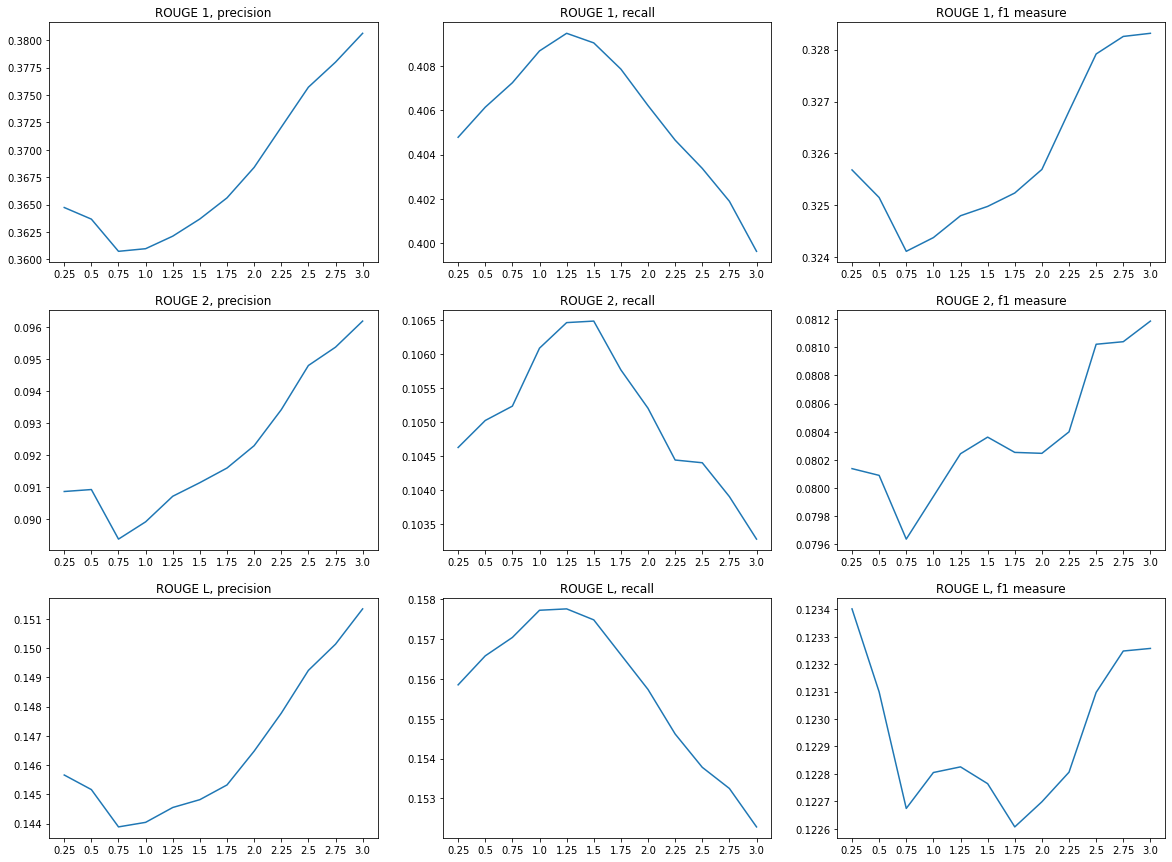

In [218]:
fig, axs = plt.subplots(3, 3, figsize=(20, 15))

axs[0][0].plot([rouge_list[0] for rouge_list in res_rouge_w]);
axs[0][0].set_xticks(range(len(weight_range)))
axs[0][0].set_xticklabels(weight_range)
axs[0][0].set_title('ROUGE 1, precision')
axs[0][1].plot([rouge_list[1] for rouge_list in res_rouge_w]);
axs[0][1].set_xticks(range(len(weight_range)))
axs[0][1].set_xticklabels(weight_range)
axs[0][1].set_title('ROUGE 1, recall')
axs[0][2].plot([rouge_list[2] for rouge_list in res_rouge_w]);
axs[0][2].set_xticks(range(len(weight_range)))
axs[0][2].set_xticklabels(weight_range)
axs[0][2].set_title('ROUGE 1, f1 measure')

axs[1][0].plot([rouge_list[3] for rouge_list in res_rouge_w]);
axs[1][0].set_xticks(range(len(weight_range)))
axs[1][0].set_xticklabels(weight_range)
axs[1][0].set_title('ROUGE 2, precision')
axs[1][1].plot([rouge_list[4] for rouge_list in res_rouge_w]);
axs[1][1].set_xticks(range(len(weight_range)))
axs[1][1].set_xticklabels(weight_range)
axs[1][1].set_title('ROUGE 2, recall')
axs[1][2].plot([rouge_list[5] for rouge_list in res_rouge_w]);
axs[1][2].set_xticks(range(len(weight_range)))
axs[1][2].set_xticklabels(weight_range)
axs[1][2].set_title('ROUGE 2, f1 measure')

axs[2][0].plot([rouge_list[6] for rouge_list in res_rouge_w]);
axs[2][0].set_xticks(range(len(weight_range)))
axs[2][0].set_xticklabels(weight_range)
axs[2][0].set_title('ROUGE L, precision')
axs[2][1].plot([rouge_list[7] for rouge_list in res_rouge_w]);
axs[2][1].set_xticks(range(len(weight_range)))
axs[2][1].set_xticklabels(weight_range)
axs[2][1].set_title('ROUGE L, recall')
axs[2][2].plot([rouge_list[8] for rouge_list in res_rouge_w]);
axs[2][2].set_xticks(range(len(weight_range)))
axs[2][2].set_xticklabels(weight_range)
axs[2][2].set_title('ROUGE L, f1 measure')
